In [2]:
%config Completion.use_jedi = False
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

# Table of Content
1. [General Information](#info)
2. [Exploring Data](#eda) <br/>
    2.1 [Visual Examples](#vis) <br/>
    2.2 [Dataset Details](#data) <br/>
3. [Dataset Split Information](#split)
4. [Short Summary](#sum)
5. [Next Step](#next)


# 1. General Information <a class="anchor" id="info"></a>

**Important: Content, both literal and graphical, is copyrighted by Wizards of the Coast. This is a fan project with non-comercial usage!**

I made my own little "MNIST" example for multi-label classification by using Magic the Gathering cards from mtgpics. I guess that there is no real life use case for it but as I mentioned in the readme this project is more for learning purposes.

#### <u>Setup:</u>
- I used the data of the following decks: m11, m12, m13, m14, m19, m20 and m21, downloaded with the scraper in [scripts](../scripts/mtgpics_card_scraper.py)
- I sorted the data in the following categories:
    - color
    - creatures
    - artifacts
    - planeswalkers (I didn't sort them after color cause there were only 50 planeswalker in all 7 decks -> but I guess it will work aswell)
    - all spells/instants are classified as "special"
    - All special land cards or cards with two colors got removed to keep the amount of possible classes smaller
- It took about ~6 mins per deck to sort the data
- For splitting the data I used the module [split-folders](https://github.com/jfilter/split-folders) (70% Train, 15% Validation, 15% Test with group_prefix to True)

The folder structure with the default separator "-" for the MultiLabelImageFolder should look like this:

<img src="../img/folder_structure.png" width=350 height=300 />

For more details about the custom dataset class look [here](../src/custom_datasets.py)


# 2. Exploring Data <a class="anchor" id="eda"></a>

Let's display some images and look for the class distribution

### 2.1 Visual Examples <a class="anchor" id="vis"></a>

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(445, 312, 3)


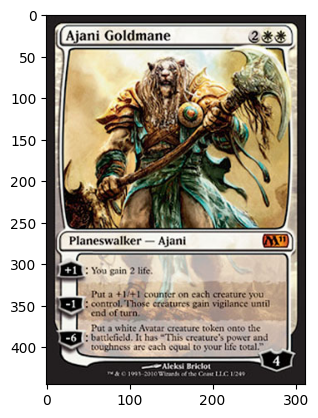

In [4]:
# Display one image with shape
img_path = "../data/raw/m11/11m_001_Ajani_Goldmane.jpg"
img = mpimg.imread(img_path)
plt.imshow(img)
print(img.shape);

### Let's look for more examples in our image dataset

In [5]:
from src.visuals import plot_random_images

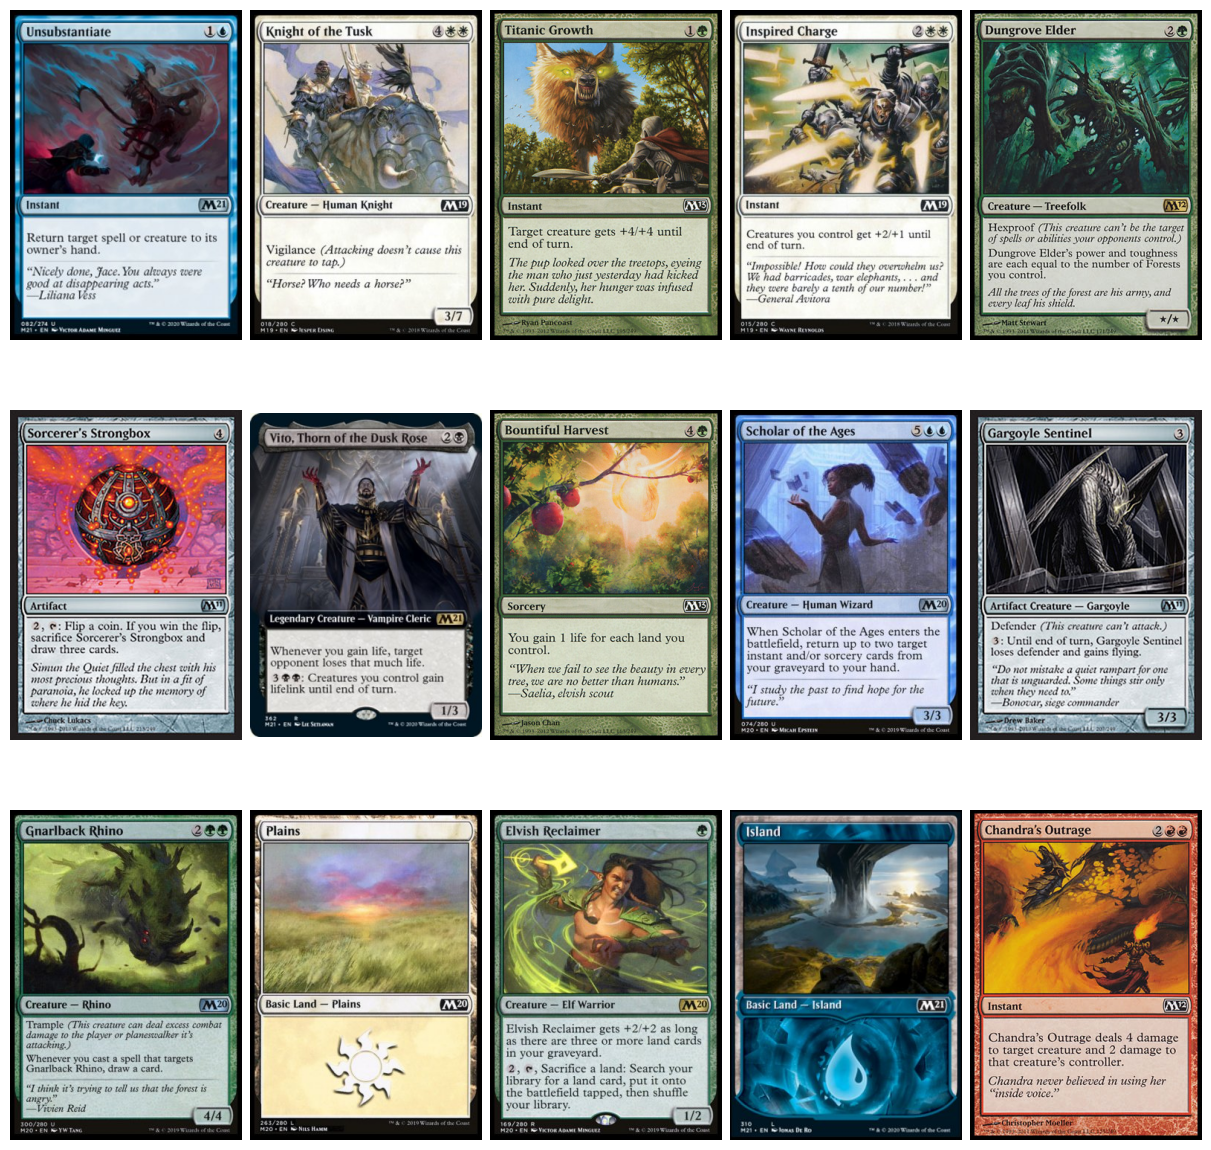

In [6]:
path_image_folder = "../data/sorted_images/"
plot_random_images(image_folder=path_image_folder)

### 2.2 Dataset Details <a class="anchor" id="data"></a>

Let's check if the custom dataset lists all possible classes

In [7]:
from src.utils import print_dataset_information, calculate_mean_stds_per_channel, check_img_shapes

In [8]:
print_dataset_information(path_image_folder) # TODO: move the function to __str__ of MultiLabelImageFolder

Dataset Summary
--------------------------------------------------

The dataset contains 1894 images
The possible classes are:
Artifact, Black, Blue, Creature, Green, Mana, Planeswalker, Red, Special, White

The folders are structured as followed:

0: artifact
1: artifact and creature
2: black and creature
3: black and mana
4: black and special
5: blue and creature
6: blue and mana
7: blue and special
8: green and creature
9: green and mana
10: green and special
11: planeswalker
12: red and creature
13: red and mana
14: red and special
15: white and creature
16: white and mana
17: white and special

These represents the possible class combinations in your dataset
--------------------------------------------------


In [9]:
# Checking the possible image shapes in my dataset
shape_counts = check_img_shapes(path_image_folder)
# Displays the image shape (h,w) as a key and the count as the value
print(shape_counts)

Counter({(445, 312): 1847, (454, 325): 47})


In [10]:
# print height to width ratio
for shape in shape_counts.keys():
    print(shape[0] / shape[1])

1.4262820512820513
1.396923076923077


In [11]:
# Attention: don't use this values for the transformation! Use the means/stds of your trainingset
channel_means, channel_stds = calculate_mean_stds_per_channel(path_image_folder)
print(channel_means) # Order: RGB
print(channel_stds)

[0.50565335 0.48533268 0.4632135 ]
[0.31012781 0.30387177 0.30337491]


# 3. Dataset Split Information <a class="anchor" id="split"></a>

In [12]:
import os
from pathlib import Path
from collections import Counter

import pandas as pd
import numpy as np

from src.custom_datasets import MultiLabelImageFolder

In [13]:
# paths to image datasets (train, val, test)
data_dirs = {"train": "../data/0.7-0.15-0.15_split/train/",
             "test": "../data/0.7-0.15-0.15_split/test/",
             "val": "../data/0.7-0.15-0.15_split/val/"}

In [15]:
train_set = MultiLabelImageFolder(data_dirs["train"])
val_set = MultiLabelImageFolder(data_dirs["val"])
test_set = MultiLabelImageFolder(data_dirs["test"])

print("Dataset Lengths")
print(20*"-")
print(f"Train: {len(train_set)}\nValidation: {len(val_set)}\nTest: {len(test_set)}")

Dataset Lengths
--------------------
Train: 1317
Validation: 276
Test: 301


It's a bit odd that the validation set is quite smaller than the test set after using split-folders. I guess it's because of the parameter group_prefix to keep the group distribution evenly balanced. I will live with that but let's take a closer look to the class distributions in each set.

In [16]:
# Helperfunctions to create a Dataframe with the class counts of each set
def get_class_distribution(data_dir: str, sep="-") -> Counter:
    class_counter = Counter()
    
    for dirpath, _, filenames in os.walk(data_dir):
        if not filenames or dirpath == data_dir:
            continue
        
        count = len(filenames)
        target_classes = Path(dirpath).stem.split(sep)
        
        for target_class in target_classes:
            class_counter[target_class] += count
                
    return class_counter
    

def show_train_val_test_distribution(data_dirs: dict) -> pd.DataFrame:
    
    tvt_data = {name: get_class_distribution(data_dir) for name, data_dir in data_dirs.items()}
    
    return pd.DataFrame.from_dict(tvt_data)

In [17]:
class_distributions: pd.DataFrame = show_train_val_test_distribution(data_dirs)
x_sorted = ["black", "blue", "green", "red", "white","artifact","planeswalker", "creature", "special", "mana" ]
class_distributions = class_distributions.reindex(x_sorted) # colors first

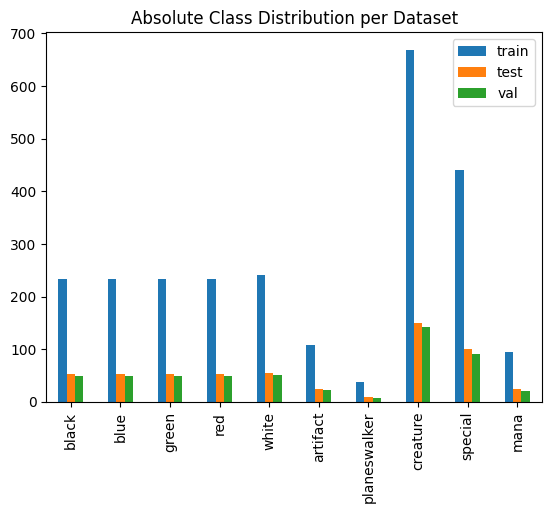

In [18]:
class_distributions.plot.bar(title="Absolute Class Distribution per Dataset");

In [22]:
(class_distributions / class_distributions.sum())

,train,test,val
black,0.092387,0.092014,0.092628
blue,0.092387,0.092014,0.092628
green,0.092387,0.092014,0.092628
red,0.092387,0.092014,0.092628
white,0.095559,0.095486,0.094518
artifact,0.042427,0.043403,0.043478
planeswalker,0.014671,0.015625,0.013233
creature,0.265266,0.260417,0.268431
special,0.174861,0.173611,0.172023
mana,0.037669,0.043403,0.037807


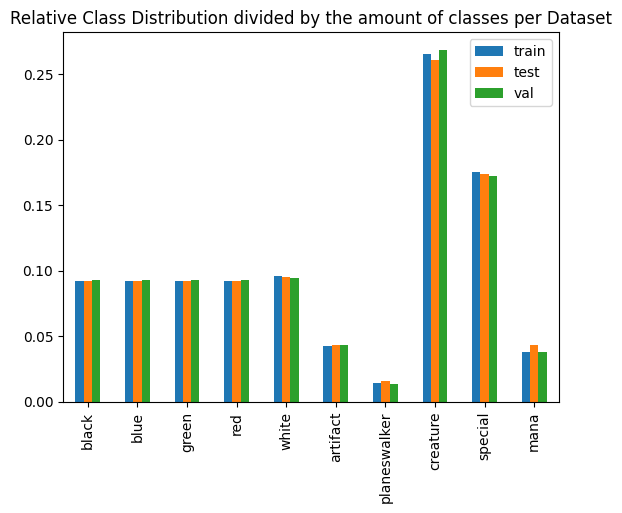

In [23]:
# keep in mind total count classes > total count images! One card/images can have mutiple classes
(class_distributions / class_distributions.sum()).plot.bar(title="Relative Class Distribution divided by the amount of classes per Dataset");

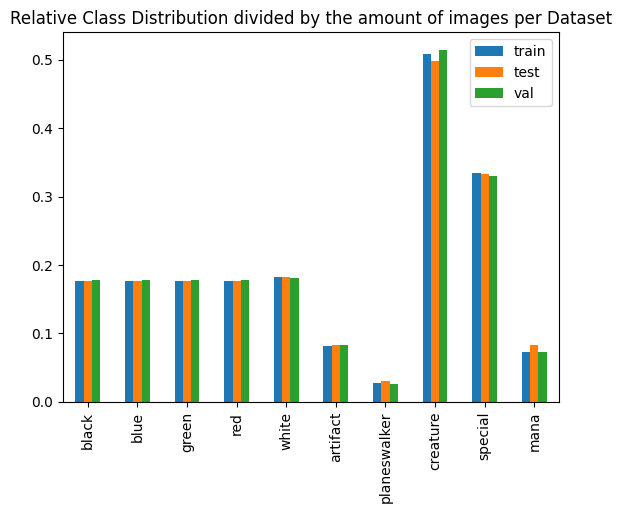

In [24]:
# Im not sure if the first plot is confusing so that's why I create a barplot relative to amount of images per dataset.
# It only changes the height on the y-axis.

image_counts = [len(train_set), len(test_set), len(val_set)]
class_distributions.div(image_counts).plot.bar(title="Relative Class Distribution divided by the amount of images per Dataset");

In [25]:
class_distributions.div(image_counts)

,train,test,val
black,0.176917,0.176080,0.177536
blue,0.176917,0.176080,0.177536
green,0.176917,0.176080,0.177536
red,0.176917,0.176080,0.177536
white,0.182992,0.182724,0.181159
artifact,0.081245,0.083056,0.083333
planeswalker,0.028094,0.029900,0.025362
creature,0.507973,0.498339,0.514493
special,0.334852,0.332226,0.329710
mana,0.072134,0.083056,0.072464


In [26]:
# calculating mean and std for the trainingset
calculate_mean_stds_per_channel(data_dirs["train"])

(array([0.50476729, 0.48440304, 0.46218942]),
 array([0.30981703, 0.3034715 , 0.30258951]))

# 4. Short Summary <a class="anchor" id="sum"></a>

**<u>Dataset</u>**

| | Train | Validation | Test | Total
|---:| :--- | :--- | :--- | :--- |
|Size| 1317 | 276| 301| 1894

**<u>Image Data</u>**

Shapes: 

- (445, 312): 1847 times - ratio: 1.4262820512820513
- (454, 325): 47 times - ratio: 1.396923076923077

Mean/Std Channel of the whole set (RGB):

| | R | G | B | 
|---:| :--- | :--- | :--- | 
| Mean| 0.50565335 | 0.48533268| 0.4632135|
| Std | 0.31012781 | 0.30387177| 0.30337491|

Mean/Std Channel of the training set (RGB):

| | R | G | B | 
|---:| :--- | :--- | :--- | 
| Mean| 0.50476729 | 0.48440304| 0.46218942|
| Std | 0.30981703 | 0.3034715| 0.30258951|


**<u>Plots</u>**

The relative distribution plot shows that:
- the groups are evenly balanced across the datasets
- Creatures and special cards appear most frequently
- colors are distributed evenly (~18%) 


sitenote: all colors + artifact + planeswalker ≈ 100% of the images

TODO: Create plots with RGB histograms?
TODO: Check the means/std function

# 5. Next Step <a class="anchor" id="next"></a> - [Notebook Training](01_Training_with_Lightning.ipynb)
- train a model which can classify in one Step/Model:
    - the color of a card or artifact/planeswalker
    - whether it's a creature, special or mana card

#